## Supervised Learning
## Project: Finding Donors for *CharityML*

## Table of Contents

1. [Introduction](#1-bullet)
2. [Data Exploration](#2-bullet)
3. [Data Preprocessing](#3-bullet)
4. [Evaluating Model Performance](#4-bullet)
5. [Improving Results](#5-bullet)
6. [Feature Importance](#6-bullet)

## 1. Introduction <a class="anchor" id="1-bullet"></a>

I employed several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. I then chose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. My goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## 2. Data Exploration <a class="anchor" id="2-bullet"></a>

Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [20]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
import seaborn as sns

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=3))

len(list(data))

data.info()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


Look at the output of data.info(), you notice that there is no missing values in each column. This is important to check because some learning algorithms don't handle missing values well.

Out of 14 variables, there are eight categorical(non-numeric) variables. Typically, learning algorithms expect input to be numeric, which requires that non-numeric variables be converted. I implement the conversion later in the data preprocessing section.

As for now, because of categorical variables, below scatter plot and correlation table do not provide much information.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000167C8AB1D30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000167C8E38390>]], dtype=object)

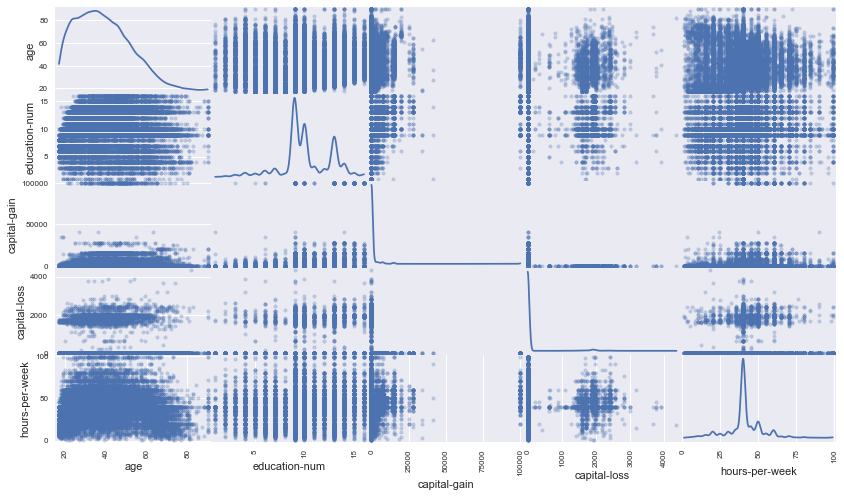

In [4]:
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

In [7]:
data.corr()

,age,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,0.037623,0.079683,0.059351,0.101992
education-num,0.037623,1.000000,0.126907,0.081711,0.146206
capital-gain,0.079683,0.126907,1.000000,-0.032102,0.083880
capital-loss,0.059351,0.081711,-0.032102,1.000000,0.054195
hours-per-week,0.101992,0.146206,0.083880,0.054195,1.000000


### Implementation: Data Exploration
A cursory investigation of the dataset determines how many individuals fit into either group, and tells us about the percentage of these individuals making more than \$50,000. In the code cell below, I computed the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [15]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data[(data.income == '>50K')].shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[(data.income == '<=50K')].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records * 100

# Print the results
print ("Total number of records: {}".format(n_records))
print ("Individuals making more than $50,000: {}".format(n_greater_50k))
print ("Individuals making at most $50,000: {}".format(n_at_most_50k))
print ("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


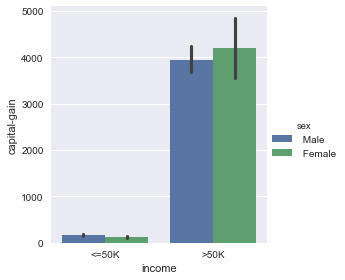

In [17]:
sns.factorplot('income', 'capital-gain', hue = 'sex', data=data, kind = 'bar')

----
## 3. Data Preprocessing <a class="anchor" id="3-bullet"></a>

Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

In this section, I applied four preprocessing techniques as follows:

- Logarithmic transformation for skewed continuous features
- Normailization for numeric features
- One hot encoding for categorical features
- Shuffle and split to produce train and test datasets

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`.

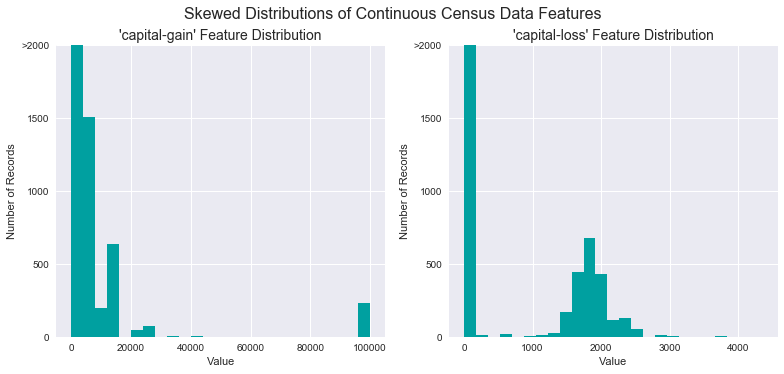

In [21]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)


For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: **The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.**

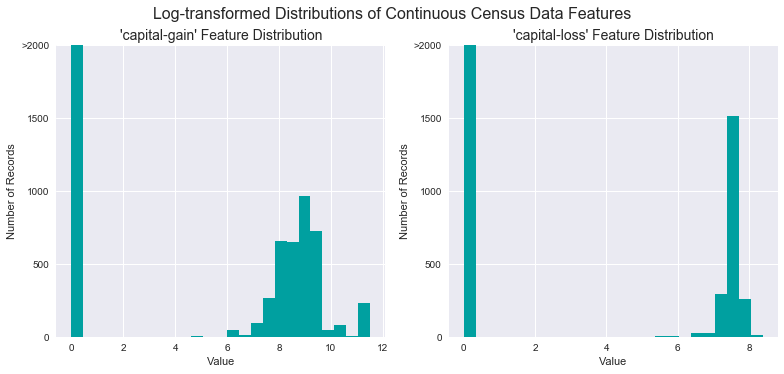

In [22]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1)) # note +1

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, **normalization ensures that each feature is treated equally when applying supervised learners**. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [23]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

# confirm the transformation
features_raw.describe()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,0.295177,0.607897,0.011014,0.020339,0.407531
std,0.181067,0.170192,0.075065,0.092965,0.122526
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.533333,0.000000,0.000000,0.397959
50%,0.273973,0.600000,0.000000,0.000000,0.397959
75%,0.410959,0.800000,0.000000,0.000000,0.448980
max,1.000000,1.000000,1.000000,1.000000,1.000000


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [24]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# Encode the 'income_raw' data to numerical values
income = np.where(income_raw == ">50K", 1, 0)

# NOTE: Another way we could do this is with LabelEncoder
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# income = le.fit_transform(income_raw)
# # print one hot
# print income
# # then we can reverse it with
# print le.inverse_transform(income)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))

print (encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [25]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


C:\Users\K\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
size = 10
X_train.iloc[:size,]

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
13181,0.410959,0.600000,0.0,0.000000,0.500000,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
10342,0.438356,0.533333,0.0,0.000000,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
20881,0.054795,0.666667,0.0,0.000000,0.357143,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
24972,0.301370,0.866667,0.0,0.453857,0.448980,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
43867,0.246575,0.600000,0.0,0.000000,0.500000,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4124,0.315068,0.533333,0.0,0.000000,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
17641,0.054795,0.600000,0.0,0.000000,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
17273,0.561644,0.400000,0.0,0.000000,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
41191,0.109589,0.800000,0.0,0.000000,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5386,0.232877,0.800000,0.0,0.000000,0.377551,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


----
## 4. Evaluating Model Performance <a class="anchor" id="4-bullet"></a>
In this section, I investigated four different algorithms, and determine which is best at modeling the data. Three of these algorithms are supervised learners, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*

In [27]:
# Calculate accuracy
import numpy as np
from sklearn.metrics import accuracy_score
X = pd.concat([X_train, X_test])
y = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_test)])

y_naive = np.zeros(shape=(y.shape[0],))
y_naive.fill(1)
accuracy = accuracy_score(y, y_naive)

# Calculate F-score using the formula above for beta = 0.5
from sklearn.metrics import fbeta_score
fscore = fbeta_score(y, y_naive, 0.5)

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


In [28]:
### Same calucation by hand ---------------------
# since the model always predicts an individual made more than 50K
true_negative, false_negative = 0, 0

# the model captures all true positive and what remains are false positive
true_positive = n_greater_50k
false_positive = n_at_most_50k

recall = true_positive / (true_positive + false_negative)
precision = true_positive / (true_positive + false_positive)

accuracy = true_positive / n_records
fscore = (1 + 0.5**2) * (precision*recall) / ((0.5**2*precision) + recall)

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

**Logistic Regression**

- **Strength**: Fast and easy to interpret outputs from a model. Works for binary classification problem.
- **Weakenss**: Cannot model complex nonlinear relationships because a Logistic Regression model is a linear classifier. It cannot fit non-linear data.
- **What makes this model a good candidate**: Because it is fast and easy to interpret. This will be a good baseline to compare with other models.
- **Industrial application**: binary classification problems. E.g. predicting default in banking industry

**Random Forest(Ensemble Method)**

- **Strength**: Less prone to overfitting. Can model complex relationships. Handles high dimensional spaces well. Great for unbalanced datasets
- **Weakness**: Difficult to interpret. Tend to overfit a dataset.
- **What makes this model a good candidate**: Random Forest can handle a large number of features.
- **Industrial application**: The first look at dataset since it provides feature importance along with predictions. Apt at almost any machine leanring problem.

**Support Vector Machines (SVM)**

- **Strength**: Handles feature intesnse data and models complex nonlinear relationships
- **Weakenss**: Requires siginificant memory. Needs to select a good kernel function. Typically much slower. The output parameter are not interpretable
- **What makes this model a good candidate**:The data set has a large number of features. This doesn't work against SVM.
- **Industrial application**: Text processing, genomic data processing.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model, it's important to create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. This implementation here will be used in the following section.
In the code block below, I implemented the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.

In [29]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score


def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[0:sample_size], y_train[0:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[0:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Print
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, I implemented the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

In [30]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# Initialize the three models
clf_A = LogisticRegression(random_state=10)
clf_B = RandomForestClassifier(random_state=10)
clf_C = svm.SVC(random_state=10)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = round(X_train.shape[0])
samples_10 = round(samples_100 * 0.1)
samples_1 = round(samples_100 * 0.01)

LogisticRegression trained on 362 samples.
LogisticRegression trained on 3618 samples.
LogisticRegression trained on 36177 samples.
RandomForestClassifier trained on 362 samples.
RandomForestClassifier trained on 3618 samples.
RandomForestClassifier trained on 36177 samples.


C:\Users\K\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 362 samples.
SVC trained on 3618 samples.
SVC trained on 36177 samples.


C:\Users\K\Documents\GitHubLocal\machine-learning-master\machine-learning-master\projects\finding_donors\visuals.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[j/3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
C:\Users\K\Documents\GitHubLocal\machine-learning-master\machine-learning-master\projects\finding_donors\visuals.py:76: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[j/3, j%3].set_xticks([0.45, 1.45, 2.45])
C:\Users\K\Documents\GitHubLocal\machine-learning-master\machine-learning-master\projects\finding_donors\visuals.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[j/3, j%3].set_xticklabels(["1%", "10%", "100%"])
C:\Users\K\Documents\GitHubLocal\machine-learning-master\machine-learning-master\projects\finding

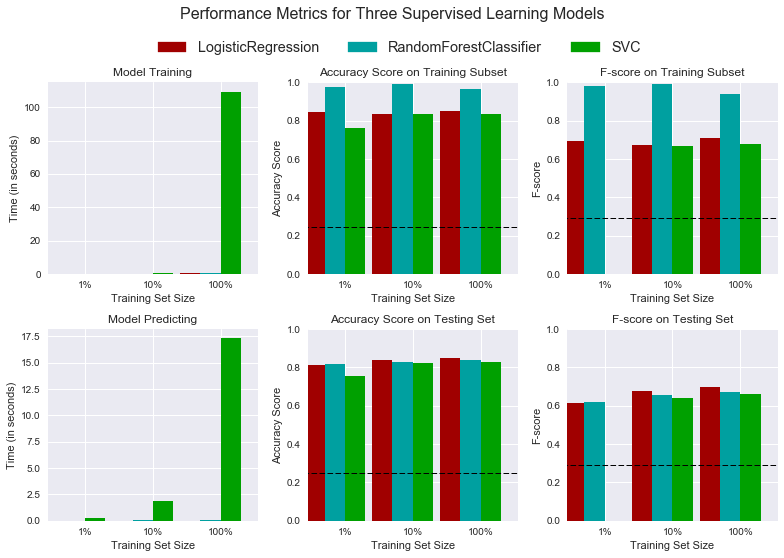

In [31]:
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [32]:
results

{'LogisticRegression': {0: {'acc_test': 0.81227197346600333,
   'acc_train': 0.84333333333333338,
   'f_test': 0.61190673452479583,
   'f_train': 0.69444444444444431,
   'pred_time': 0.007005214691162109,
   'train_time': 0.0071353912353515625},
  1: {'acc_test': 0.83714759535655059,
   'acc_train': 0.83666666666666667,
   'f_test': 0.67526977416842804,
   'f_train': 0.67164179104477617,
   'pred_time': 0.008005857467651367,
   'train_time': 0.027623414993286133},
  2: {'acc_test': 0.84831398562741844,
   'acc_train': 0.84999999999999998,
   'f_test': 0.69929332348908335,
   'f_train': 0.70895522388059706,
   'pred_time': 0.006506204605102539,
   'train_time': 0.5889184474945068}},
 'RandomForestClassifier': {0: {'acc_test': 0.81558872305140961,
   'acc_train': 0.97666666666666668,
   'f_test': 0.62099584129481855,
   'f_train': 0.97891566265060259,
   'pred_time': 0.01801276206970215,
   'train_time': 0.017512798309326172},
  1: {'acc_test': 0.82985074626865674,
   'acc_train': 0.9899

----
## 5. Improving Results <a class="anchor" id="5-bullet"></a>

In this final section, I chose from the three supervised learning models the *best* model to use on the data. I then performed a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*

**Answer: **

Look at the model performances with the training data set, Random Forest performs best. However, the model performances with the test dataset shows different results: Logistic regression performs best. Random Forest's lower performance with the test data set agasint the one with the training data set implies that the model remembers the training data set. In ohter words, it's overfitting. Thus, evaluating the scores for two metrices, I choose ligistic regression instead of random forest.

Prediction and training time are immportant factor to consider in selecting a model. Clearly, the fastest model is logistic regression and the slowest is support vector machine. This is expected given a complexity of each model I have selected as logistic model is the simplest and support vector machine is the most memory consuming.

Considering the accuracy, f-score, and the running time, I choose logistic regression.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 

Let me explain a little bit about a model I chose to predict individuals with income more than 50K, who are good potential donors. After comparing three candidate models, I selected a model called logistic regression. Logistic regression is a simple, fast and powerful. The model is especially good at solving a binary classification problem which is to predict a binary outcome. In our case, to predict two groups of people: people with more than 50K income and people with less than 50K income.

**Assumption**

Key assumption for logistic regression is input space can be separated into two regions by a linear boundary. This is important because logistic regression cannot represent non-linear relationship between inputs and an output

**Learn the dataset**

First, logistic regression model learns the data. What the model does is to learn the boundary to separate two target groups. The model uses a technique called maximum likelihood estimation is to draw the boundary that is represented as a linear fucntion of features and co-efficients (weights). The weigths are assigned for each feature according to its importance.
 
**Predict the class**

Take all feature values mupltiply them with their weights accordingly. We then sum up all the results. This final result is applied to a special function called Sigmoid/Logistic function which only outputs values between 0-1 which can be interpreted as the probability of our positive label.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. In the code cell below, you implemented the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [33]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = LogisticRegression(random_state=10)

# Create the parameters list you wish to tune
parameters = {'C': (0.01, 0.1, 1.0),
              'penalty':('l1', 'l2')}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring = scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8483
F-score on testing data: 0.6993

Optimized Model
------
Final accuracy score on the testing data: 0.8484
Final F-score on the testing data: 0.6998


In [34]:
print(best_clf)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=10, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.2478        |      0.8483       |     0.8484      |
| F-score        |       0.2917        |      0.6993       |     0.6998      |


**Answer: **

As shown in the chart above, optimized model marked the best score for accuracy and f-score. It turns out that the optimization by gridsearch didn't improve unoptimized model much: the unoptimized model and the optimized model show very close scores. However, the optimized model clearly performs better than the benchmarke predictor.

----
## 6. Feature Importance <a class="anchor" id="6-bullet"></a>

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**

I select "occupation", "education-level", "age", "work-class", "sex" as the five most important features for prediciton. They are in descending order as "occupation" is rank 1 and "sex" as rank 5. I think occupation is a good indicator for income level because each occupation usually has a different average income. I read some ariticle saying "education-level" collerates with income. The higher her education achievement is, the higher her income is. "age" is also quite obivous indicator. The older she is, the higher her income is. Same logic to "occupation" goes to "work-class". Lastly, I saw a stats showing a man has higher income average than a woman. Thus, "sex" correlates with income.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, I implemented the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

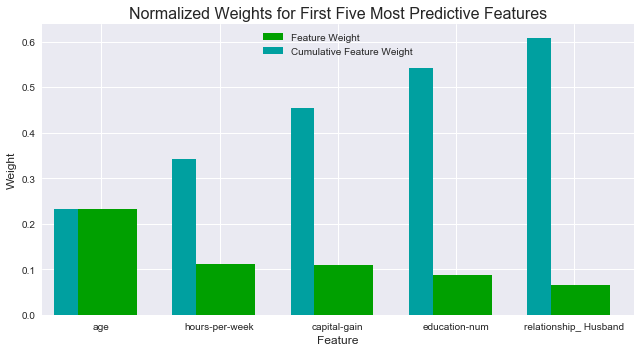

In [35]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

# Train the supervised model on the training set 
model = clf.fit(X_train, y_train)

# Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

|     Rank       |     Estimation      |       Result      |
| :------------: | :-----------------: | :---------------: |
|       1        |     "occupation"    |       "age"       |
|       2        |  "education-level"  | "marital-status"  |
|       3        |        "age"        | "hours-pwer-week" |
|       4        |    "work-class"     |   "capital-gain"  |
|       5        |        "sex"        |  "education-num"  |

Above chart summarizes the resutls against my estimations for feature importance. Overall, there is no suprise to find out "Result", "hours-pwer-week", "capital-gain" and "education-num" have higher influence on the income levels.

However, I found quite interesting to see "martial-status" as the second most important feature. One possible interpretation is a person with higher income tend to marry and a person with low income tend not to marry.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [36]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print ("Final Model trained on full data\n------")
print ("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print ("\nFinal Model trained on reduced data\n------")
print ("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8484
F-score on testing data: 0.6998

Final Model trained on reduced data
------
Accuracy on testing data: 0.8296
F-score on testing data: 0.6577


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

I will defintely consider droping features to the five most important ones because the test clearly shows that limiting features doesn't sacrifice very much. In fact, accuracy remains high as 0.8348 compared to original score 0.8484. This is true to f-score: 0.6685 vs. original score 0.6998. If training time was a factor, selecting only important feature would be a great option for this problem.